In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input
from tensorflow.keras.layers import BatchNormalization, Conv3DTranspose
from tensorflow.keras.layers import UpSampling3D, Conv3D
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer
import matplotlib.pyplot as plt



In [2]:
file_path = "/Users/siddharth/Downloads/modelnet10.npz"
data = np.load(file_path, allow_pickle=True)

In [3]:
train_voxel = data["train_voxel"] # Training 3D voxel samples
test_voxel = data["test_voxel"] # Test 3D voxel samples
train_labels = data["train_labels"] # Training labels (integers from 0 to 9)
test_labels = data["test_labels"] # Test labels (integers from 0 to 9)
class_map = data["class_map"] # Dictionary mapping the labels to their class names.

In [4]:
# Check the keys in the loaded data
print(data.keys())

# Access specific components (e.g., training samples and labels)
train_voxel = data["train_voxel"]
train_labels = data["train_labels"]


KeysView(NpzFile '/Users/siddharth/Downloads/modelnet10.npz' with keys: train_voxel, test_voxel, train_labels, test_labels, class_map)


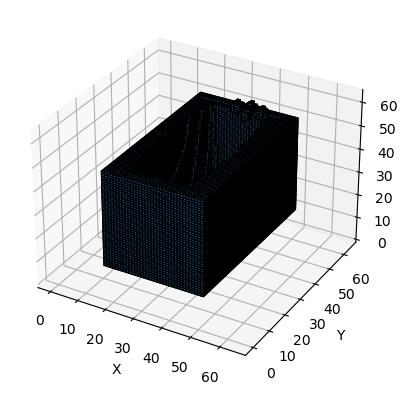

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Visualize a single 3D voxel sample (adjust the index as needed)
sample_index = 0  # Change this to the index of the sample you want to visualize
sample = train_voxel[sample_index]

# Create a figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the voxels
ax.voxels(sample, edgecolor='k')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [6]:
# Assuming you have an index value for your model
#index = 0  # Replace with the actual index value you want to visualize

#ax = plt.figure().add_subplot(projection='3d')
#ax.voxels(train_voxel[index])  # Assuming train_voxel is your voxel map data
#plt.show()
# Define constants
#LATENT_DIM = 100
#BATCH_SIZE = 64
#EPOCHS = 50
#print(train_voxel.shape)


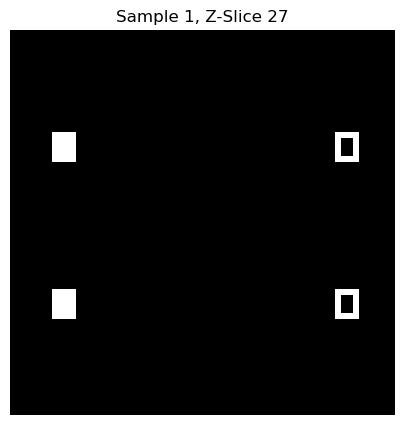

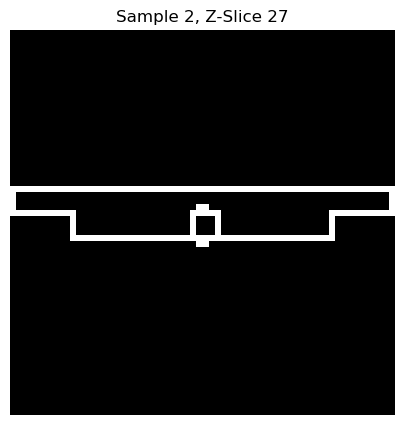

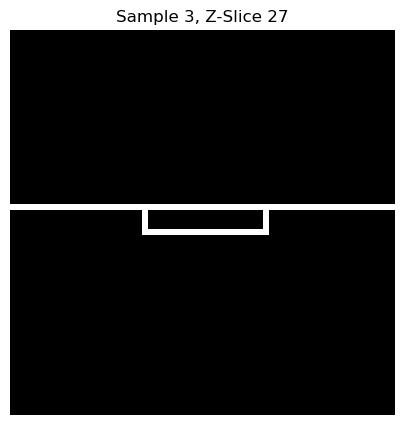

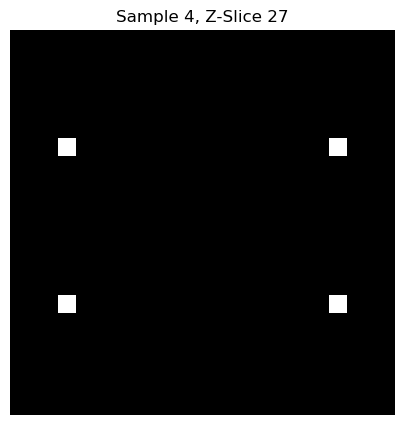

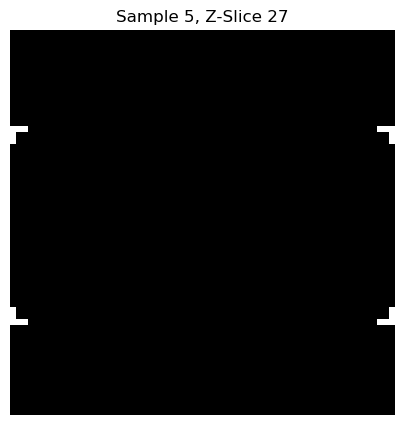

In [7]:
# TASK 1 - Display 5 random 2D slices from the training dataset

import random
import matplotlib.pyplot as plt

sample_indices = random.sample(range(train_voxel.shape[0]), 5)

# Choose a random slice along the z-dimension (z-index)
z_index = random.randint(0, train_voxel.shape[2] - 1)

for i, idx in enumerate(sample_indices):
    sample = train_voxel[idx]  # Assuming your training data is stored in train_voxel
    plt.figure(figsize=(5, 5))
    
    # Display the selected 2D slice along the z-dimension
    plt.imshow(sample[:, :, z_index], cmap='gray')
    
    plt.title(f"Sample {i+1}, Z-Slice {z_index}")
    plt.axis('off')
    plt.show()


In [12]:
# Generator model
generator = Sequential()

# Input layer
generator.add(Input(shape=(200,)))
generator.add(Dense(4 * 4 * 4 * 32, use_bias=False))
generator.add(BatchNormalization())
generator.add(ReLU())
generator.add(Reshape((4, 4, 4, 32)))

# Convolutional layers
generator.add(Conv3DTranspose(512, kernel_size=4, strides=1, padding="same"))
generator.add(BatchNormalization())
generator.add(ReLU())

generator.add(Conv3DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(BatchNormalization())
generator.add(ReLU())

generator.add(Conv3DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(BatchNormalization())
generator.add(ReLU())

generator.add(Conv3DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(BatchNormalization())
generator.add(ReLU())

# Output layer
generator.add(Conv3DTranspose(1, kernel_size=4, strides=2, padding="same", activation="sigmoid"))

# Summary of the generator
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2048)              409600    
                                                                 
 batch_normalization_5 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 4, 32)       0         
                                                                 
 conv3d_transpose (Conv3DTr  (None, 4, 4, 4, 512)      1049088   
 anspose)                                                        
                                                                 
 batch_normalization_6 (Bat  (None, 4, 4, 4, 512)     

In [8]:
# Discriminator model
discriminator = Sequential()

# Input layer
discriminator.add(Input(shape=(64, 64, 64, 1)))

# Convolutional layers
discriminator.add(Conv3D(64, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(BatchNormalization())

discriminator.add(Conv3D(128, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(BatchNormalization())

discriminator.add(Conv3D(256, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(BatchNormalization())

discriminator.add(Conv3D(512, kernel_size=4, strides=2, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(BatchNormalization())

# Output layer
discriminator.add(Conv3D(1, kernel_size=4, strides=1, padding="same", activation="sigmoid"))

# Flatten and dense layers
discriminator.add(Flatten())
discriminator.add(Dense(1))

# Summary of the discriminator
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 32, 32, 64)    4160      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32, 64)    0         
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32, 64)    256       
 chNormalization)                                                
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 16, 16, 128)   524416    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 16, 128)   0         
                                                                 
 batch_normalization_2 (Bat  (None, 16, 16, 16, 128)   512       
 chNormalization)                                     

In [9]:
# Compile the generator
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [10]:
# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

In [21]:
import tensorflow as tf
# Define the GAN model
discriminator.trainable = False
gan_input = Input(shape=(200,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 64, 1)     12485313  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 11051778  
                                                                 
Total params: 23537091 (89.79 MB)
Trainable params: 12479297 (47.60 MB)
Non-trainable params: 11057794 (42.18 MB)
_________________________________________________________________


In [14]:
# List available keys in the loaded data
#available_keys = data.keys()

# Print the available keys to identify the one for training data
#print(available_keys)


In [15]:
# Access the training data
#train_x = data['train_voxel']
# Normalize and reshape data
#train_x = train_x / 255.0
#train_x = np.expand_dims(train_x, axis=-1)

In [19]:
# Check the input data shape
print("Shape of train_voxel:", train_voxel.shape)

# Check data type and range
print("Data type of train_voxel:", train_voxel.dtype)
print("Min and Max values of train_voxel:", np.min(train_voxel), np.max(train_voxel))

# Check the batch size when using the model
print("Batch size used:", batch_size)  # Make sure it matches your model's batch size

# Check any reshaping of data
# Example: train_voxel = np.reshape(train_voxel, (batch_size, width, height, depth, channels))

# Ensure that the input data matches the expected dimensions of your GAN model's input layer.


Shape of train_voxel: (3991, 64, 64, 64)
Data type of train_voxel: float64
Min and Max values of train_voxel: 0.0 1.0
Batch size used: 32


In [22]:
# Training parameters
batch_size = 32
epochs = 3
batch_count = train_voxel.shape[0] // batch_size

# Training the GAN
for e in range(epochs):
    for _ in range(batch_count):
        
        noise = np.random.normal(0, 1, (batch_size,200))
        generated_images = generator.predict(noise)
        image_batch = train_voxel[np.random.randint(0, train_voxel.shape[0], batch_size)]

        # Create labels for real and fake data
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(image_batch, valid)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 200))
        g_loss = gan.train_on_batch(noise, valid)

    print(f"Epoch {e + 1}/{epochs}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

# Save the trained models
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

2023-09-03 13:12:29.864060: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12058904350293292096
2023-09-03 13:12:29.864082: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15665044696640185724
2023-09-03 13:12:29.864085: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9131467314244332112
2023-09-03 13:12:29.864089: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15308243645361240908
2023-09-03 13:12:29.864096: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9083545240654345937
2023-09-03 13:12:29.864106: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4795684798579590899
2023-09-03 13:12:29.864112: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv 

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/batch_normalization_1/FusedBatchNormV3' defined at (most recent call last):
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/fr/p253sg2536gclcy0s7m_d7940000gn/T/ipykernel_9384/1348748649.py", line 11, in <module>
      generated_images = generator.predict(noise)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call
      outputs = self._fused_batch_norm(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 979, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/batch_normalization_1/FusedBatchNormV3'
Detected at node 'sequential/batch_normalization_1/FusedBatchNormV3' defined at (most recent call last):
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/fr/p253sg2536gclcy0s7m_d7940000gn/T/ipykernel_9384/1348748649.py", line 11, in <module>
      generated_images = generator.predict(noise)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call
      outputs = self._fused_batch_norm(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/Users/siddharth/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 979, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/batch_normalization_1/FusedBatchNormV3'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  input must be 4-dimensional[32,4,4,4,512]
	 [[{{node sequential/batch_normalization_1/FusedBatchNormV3}}]]
	 [[sequential/leaky_re_lu_2/LeakyRelu/_24]]
  (1) INVALID_ARGUMENT:  input must be 4-dimensional[32,4,4,4,512]
	 [[{{node sequential/batch_normalization_1/FusedBatchNormV3}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_1928]

In [ ]:
Show 5 samples from the training dataset.
Show the total number of parameters of the two models.
Save the trained model for later use.
Present a figure of the history of the training loss of the discriminator and generator.
Show 4 generated 3D voxel data using the trained generator model with different latent vector z.

In [17]:
# TASK 1
#Display 5 random samples from the training dataset

import random
import matplotlib.pyplot as plt

sample_indices = random.sample(range(train_voxel.shape[0]), 5)
for i, idx in enumerate(sample_indices):
    sample = train_voxel[idx]  # Assuming your training data is stored in train_voxel
    plt.figure(figsize=(5, 5))
    plt.imshow(sample[:, :, 32, 0], cmap='gray')  # Visualize one slice of the 3D voxel data
    plt.title(f"Sample {i+1}")
    plt.axis('off')
    plt.show()


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

<Figure size 500x500 with 0 Axes>

In [ ]:
# TASK 2
# Display the total number of parameters for both models

generator_params = generator.count_params()
discriminator_params = discriminator.count_params()
print(f"Generator Parameters: {generator_params}")
print(f"Discriminator Parameters: {discriminator_params}")


In [ ]:
# TASK 3
#Save the trained model for later use.

generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

In [ ]:
# TASK 4
#Present a figure of the history of the training loss of the discriminator and generator.
# Plot the loss history

plt.figure(figsize=(10, 5))
plt.plot(discriminator_loss, label="Discriminator Loss")
plt.plot(generator_loss, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss of Discriminator and Generator")
plt.legend()
plt.show()

In [ ]:
# TASK 5
#Show 4 generated 3D voxel data using the trained generator model with different latent vector z.
# Generate and display 4 different 3D voxel data samples

for i in range(4):
    # Generate a random latent vector z
    z = np.random.normal(0, 1, (1, 200))  # Adjust the shape according to your generator's input size
    # Generate 3D voxel data using the trained generator
    generated_data = generator.predict(z)
    plt.figure(figsize=(5, 5))
    plt.imshow(generated_data[0, :, :, 32, 0], cmap='gray')  # Visualize one slice of the generated 3D voxel data
    plt.title(f"Generated Sample {i+1}")
    plt.axis('off')
    plt.show()
